# EXP 1 -Implement a basic autoencoder using TensorFlow or PyTorch and train it on a dataset like MNIST for image reconstruction.

- Dataset – Uses MNIST (28×28 handwritten digits) loaded with PyTorch DataLoader.

- Models – Implements two autoencoders:

- Fully Connected (FC) – compresses image to 3-dim latent space.

- Convolutional (CNN) – uses conv + transpose conv layers for better reconstructions.

- Training – Optimizer = Adam, loss = MSE (backprop), but also tracks MAE, BCE, SSIM, PSNR.

- Evaluation – Prints metrics per epoch and compares reconstruction quality.

- Visualization – Displays original images (top) vs. reconstructed images (bottom).

In [ ]:
!pip install pytorch-msssim


FC NN Autoencoder Epoch 1/5 | MSE: 0.0689 | MAE: 0.1542 | BCE: 0.2793 | PSNR: 11.62 | SSIM: 0.1814
FC NN Autoencoder Epoch 2/5 | MSE: 0.0485 | MAE: 0.1109 | BCE: 0.2283 | PSNR: 13.14 | SSIM: 0.3590
FC NN Autoencoder Epoch 3/5 | MSE: 0.0438 | MAE: 0.1016 | BCE: 0.2116 | PSNR: 13.58 | SSIM: 0.4324
FC NN Autoencoder Epoch 4/5 | MSE: 0.0406 | MAE: 0.0951 | BCE: 0.2007 | PSNR: 13.91 | SSIM: 0.4751
FC NN Autoencoder Epoch 5/5 | MSE: 0.0389 | MAE: 0.0918 | BCE: 0.1940 | PSNR: 14.10 | SSIM: 0.4972
CNN Autoencoder Epoch 1/5 | MSE: 0.0513 | MAE: 0.1147 | BCE: 0.2309 | PSNR: 12.90 | SSIM: 0.4122
CNN Autoencoder Epoch 2/5 | MSE: 0.0105 | MAE: 0.0349 | BCE: 0.0951 | PSNR: 19.81 | SSIM: 0.8764
CNN Autoencoder Epoch 3/5 | MSE: 0.0068 | MAE: 0.0267 | BCE: 0.0830 | PSNR: 21.68 | SSIM: 0.9235
CNN Autoencoder Epoch 4/5 | MSE: 0.0053 | MAE: 0.0233 | BCE: 0.0782 | PSNR: 22.73 | SSIM: 0.9409
CNN Autoencoder Epoch 5/5 | MSE: 0.0045 | MAE: 0.0211 | BCE: 0.0753 | PSNR: 23.50 | SSIM: 0.9511

Visualizing reconst

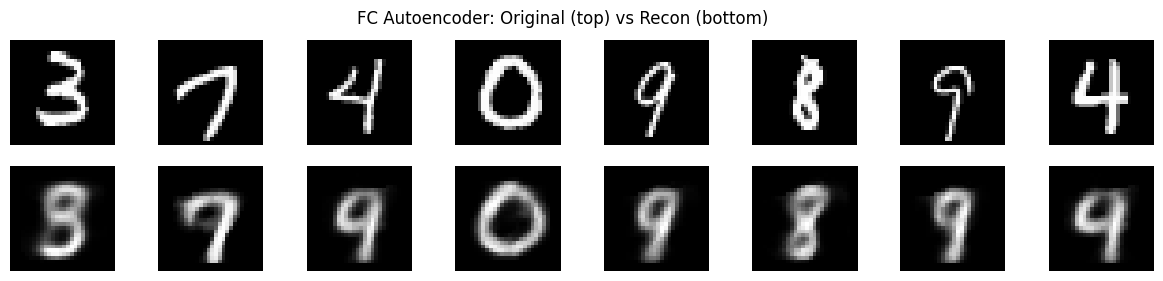

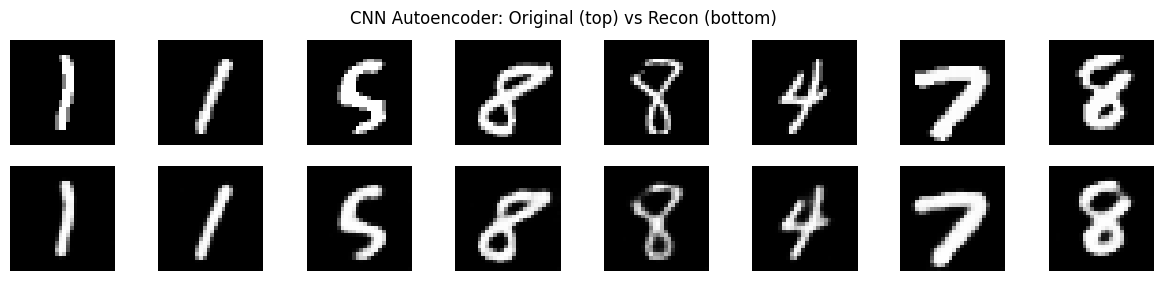

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math
try:
    from pytorch_msssim import ssim
except:
    !pip install pytorch-msssim
    from pytorch_msssim import ssim

batch_size = 128
lr = 1e-3
epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

class FCAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128), nn.ReLU(True),
            nn.Linear(128, 64), nn.ReLU(True),
            nn.Linear(64, 12), nn.ReLU(True),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12), nn.ReLU(True),
            nn.Linear(12, 64), nn.ReLU(True),
            nn.Linear(64, 128), nn.ReLU(True),
            nn.Linear(128, 28*28), nn.Sigmoid()
        )
    def forward(self, x):
        x = x.view(-1, 28*28)
        z = self.encoder(x)
        out = self.decoder(z)
        return out.view(-1, 1, 28, 28)

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(True),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
bce_loss = nn.BCELoss()

def compute_psnr(mse):
    if mse == 0: return float("inf")
    return 20 * math.log10(1.0 / math.sqrt(mse))

def train(model, name):
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    for ep in range(1, epochs+1):
        model.train()
        total_mse = total_mae = total_bce = total_ssim = 0
        for imgs, _ in train_loader:
            imgs = imgs.to(device)
            opt.zero_grad()
            outs = model(imgs)
            loss_mse = mse_loss(outs, imgs)
            loss_mae = mae_loss(outs, imgs)
            loss_bce = bce_loss(outs, imgs)
            loss_ssim = ssim(outs, imgs, data_range=1.0, size_average=True)
            loss_mse.backward()
            opt.step()
            total_mse += loss_mse.item()
            total_mae += loss_mae.item()
            total_bce += loss_bce.item()
            total_ssim += loss_ssim.item()
        avg_mse = total_mse/len(train_loader)
        avg_mae = total_mae/len(train_loader)
        avg_bce = total_bce/len(train_loader)
        avg_ssim = total_ssim/len(train_loader)
        avg_psnr = compute_psnr(avg_mse)
        print(f"{name} Epoch {ep}/{epochs} | MSE: {avg_mse:.4f} | MAE: {avg_mae:.4f} | BCE: {avg_bce:.4f} | PSNR: {avg_psnr:.2f} | SSIM: {avg_ssim:.4f}")
    return model

def show_reconstructions(model, title):
    model.eval()
    imgs, _ = next(iter(train_loader))
    imgs = imgs.to(device)
    with torch.no_grad():
        recons = model(imgs)
    imgs, recons = imgs[:8].cpu(), recons[:8].cpu()
    fig, axes = plt.subplots(2, 8, figsize=(15, 3))
    for i in range(8):
        axes[0,i].imshow(imgs[i].squeeze(), cmap="gray"); axes[0,i].axis("off")
        axes[1,i].imshow(recons[i].squeeze(), cmap="gray"); axes[1,i].axis("off")
    plt.suptitle(title)
    plt.show()

fc_model = train(FCAutoencoder(), "FC NN Autoencoder")
cnn_model = train(ConvAutoencoder(), "CNN Autoencoder")

print("\nVisualizing reconstructions...\n")
show_reconstructions(fc_model, "FC Autoencoder: Original (top) vs Recon (bottom)")
show_reconstructions(cnn_model, "CNN Autoencoder: Original (top) vs Recon (bottom)")

# EXP 2 - Explore different regularization techniques such as L1/L2 regularization or dropout and compare their effects on the autoencoder's performance.

- Dataset – Loads MNIST, flattens each image to 784-dim vectors, normalizes pixel values to [0,1].

- Models – Builds four autoencoders:

- Baseline (no regularization)

- L1 regularized (sparse encoding)

- L2 regularized (weights penalty)

- Dropout regularized (randomly drops neurons).

- Training – Each model is trained for 10 epochs on MNIST with MSE loss and Adam optimizer.

- Evaluation – Validation loss is recorded to compare reconstruction performance.

- Visualization – Plots a line graph of validation loss across epochs to show the effect of regularization.



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1078 - val_loss: 0.0412
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0379 - val_loss: 0.0295
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0281 - val_loss: 0.0229
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0220 - val_loss: 0.0186
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0182 - val_loss: 0.0160
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0159 - val_loss: 0.0142
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0142 - val_loss: 0.0130
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - val_loss: 0.0120
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - val_loss: 0.0114
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - val_loss: 0.0109
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2186 - val_loss: 0.1035
E

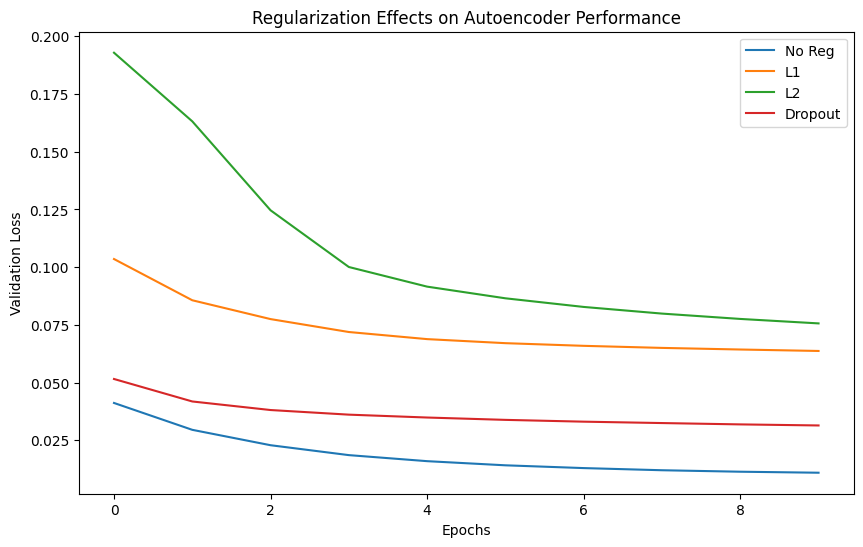

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_dim = 784  # e.g., flattened MNIST
encoding_dim = 32

input_img = keras.Input(shape=(input_dim,))
# Basic autoencoder (no reg)
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
from tensorflow.keras import regularizers

encoded_l1 = layers.Dense(
    encoding_dim,
    activation='relu',
    activity_regularizer=regularizers.l1(1e-5)
)(input_img)
decoded_l1 = layers.Dense(input_dim, activation='sigmoid')(encoded_l1)

autoencoder_l1 = keras.Model(input_img, decoded_l1)
autoencoder_l1.compile(optimizer='adam', loss='mse')
encoded_l2 = layers.Dense(
    encoding_dim,
    activation='relu',
    activity_regularizer=regularizers.l2(1e-4)
)(input_img)
decoded_l2 = layers.Dense(input_dim, activation='sigmoid')(encoded_l2)

autoencoder_l2 = keras.Model(input_img, decoded_l2)
autoencoder_l2.compile(optimizer='adam', loss='mse')
encoded_do = layers.Dense(encoding_dim, activation='relu')(input_img)
dropout = layers.Dropout(0.5)(encoded_do)
decoded_do = layers.Dense(input_dim, activation='sigmoid')(dropout)

autoencoder_do = keras.Model(input_img, decoded_do)
autoencoder_do.compile(optimizer='adam', loss='mse')
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, input_dim).astype('float32') / 255.
x_test = x_test.reshape(-1, input_dim).astype('float32') / 255.

history_baseline = autoencoder.fit(x_train, x_train,
                                   epochs=10, batch_size=256,
                                   shuffle=True, validation_data=(x_test, x_test))

history_l1 = autoencoder_l1.fit(x_train, x_train,
                               epochs=10, batch_size=256,
                               shuffle=True, validation_data=(x_test, x_test))

history_l2 = autoencoder_l2.fit(x_train, x_train,
                               epochs=10, batch_size=256,
                               shuffle=True, validation_data=(x_test, x_test))

history_do = autoencoder_do.fit(x_train, x_train,
                               epochs=10, batch_size=256,
                               shuffle=True, validation_data=(x_test, x_test))
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(history_baseline.history['val_loss'], label='No Reg')
plt.plot(history_l1.history['val_loss'], label='L1')
plt.plot(history_l2.history['val_loss'], label='L2')
plt.plot(history_do.history['val_loss'], label='Dropout')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.title('Regularization Effects on Autoencoder Performance')
plt.show()


# EXP 3 - Implement a variational autoencoder (VAE) and train it on a dataset like FashionMNIST to generate new images.


- Dataset – Uses FashionMNIST (28×28 grayscale images), loaded with PyTorch DataLoader.

- Model (VAE) – Encoder outputs mean (μ) and log-variance (logσ²), reparameterization trick samples latent vector z, decoder reconstructs image.

- Loss Function – Combines BCE (reconstruction error) + KLD (regularization) to match latent space with normal distribution.

- Training – Optimizer = Adam, trained for 10 epochs, prints Total Loss, BCE, and KLD per epoch.

- Visualization – Shows original FashionMNIST images (top row) vs. reconstructed images (bottom row).

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.79MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 168kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.13MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.5MB/s]


Epoch 1: Total Loss = 17095815.23, BCE = 16258811.06, KLD = 837004.17
Epoch 2: Total Loss = 15337056.74, BCE = 14433083.97, KLD = 903972.78
Epoch 3: Total Loss = 15000206.75, BCE = 14089928.27, KLD = 910278.47
Epoch 4: Total Loss = 14842957.27, BCE = 13919000.92, KLD = 923956.32
Epoch 5: Total Loss = 14746709.07, BCE = 13810121.73, KLD = 936587.35
Epoch 6: Total Loss = 14684696.86, BCE = 13739350.88, KLD = 945345.97
Epoch 7: Total Loss = 14637979.77, BCE = 13685189.91, KLD = 952789.87
Epoch 8: Total Loss = 14604620.37, BCE = 13646250.70, KLD = 958369.71
Epoch 9: Total Loss = 14573959.09, BCE = 13613152.91, KLD = 960806.16
Epoch 10: Total Loss = 14552349.52, BCE = 13586530.81, KLD = 965818.72


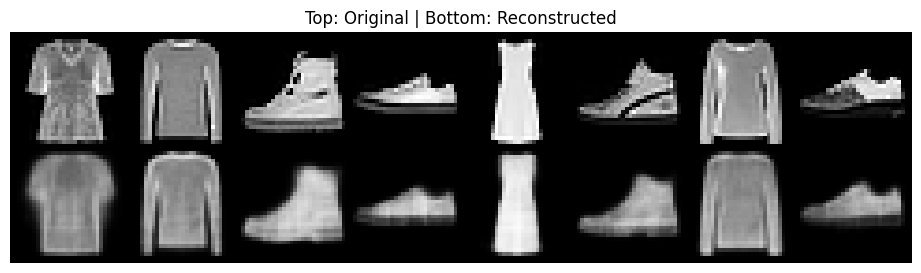

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import numpy as np

class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 400),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 28 * 28),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x_encoded = self.encoder(x)
        mu = self.fc_mu(x_encoded)
        logvar = self.fc_logvar(x_encoded)
        z = self.reparameterize(mu, logvar)
        x_decoded = self.decoder(z)
        return x_decoded.view(-1, 1, 28, 28), mu, logvar

def vae_loss_function(recon_x, x, mu, logvar):
    bce = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce + kld, bce, kld

transform = transforms.ToTensor()
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    total_bce = 0
    total_kld = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, bce, kld = vae_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        total_bce += bce.item()
        total_kld += kld.item()
        optimizer.step()
    print(f"Epoch {epoch}: Total Loss = {train_loss:.2f}, BCE = {total_bce:.2f}, KLD = {total_kld:.2f}")

def show_original_vs_reconstructed(model, data_loader, device):
    model.eval()
    data_iter = iter(data_loader)
    images, _ = next(data_iter)
    images = images.to(device)
    with torch.no_grad():
        recon, _, _ = model(images)
    images = images.cpu()
    recon = recon.cpu()
    n = 8
    comparison = torch.cat([images[:n], recon[:n]])
    grid = make_grid(comparison, nrow=n)
    plt.figure(figsize=(15, 3))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title("Top: Original | Bottom: Reconstructed")
    plt.axis('off')
    plt.show()

show_original_vs_reconstructed(model, train_loader, device)


# Exp - 4 - Implement a basic autoregressive model like the Fully Visible Sigmoid Belief Network (FVSBN) using PyTorch or TensorFlow and train it on a sequential dataset like time series data.

- Data Cleaning & EDA – Loads housing dataset, cleans dates & percentages, and visualizes trends (histograms, line plots, boxplots).

- ARIMA Forecasting – Builds ARIMA model on house price moving averages, forecasts future quarters with confidence bands.

- Time-Series Windowing – Converts moving averages into normalized binary windows for sequential modeling.

- FVSBN Model – Implements and trains a Fully Visible Sigmoid Belief Network (autoregressive model) on time-series windows.

- Results – Generates synthetic windows of MA values and shows a correlation heatmap of features.


Shape of dataset: (347, 4)

Columns: ['saledate', 'MA', 'type', 'bedrooms']

Data Types:
 saledate    object
MA           int64
type        object
bedrooms     int64
dtype: object

Missing values:
 saledate    0
MA          0
type        0
bedrooms    0
dtype: int64

Summary Stats (Numeric):
                             saledate            MA    bedrooms
count                            347  3.470000e+02  347.000000
mean   2013-09-02 15:50:19.020172800  5.481320e+05    2.867435
min              2007-03-31 00:00:00  3.167510e+05    1.000000
25%              2010-06-30 00:00:00  4.277395e+05    2.000000
50%              2013-09-30 00:00:00  5.077440e+05    3.000000
75%              2016-09-30 00:00:00  6.275155e+05    4.000000
max              2019-09-30 00:00:00  1.017752e+06    5.000000
std                              NaN  1.701934e+05    1.239875

Unique values in categorical columns:

type: ['house' 'unit']
bedrooms: [2 3 4 5 1]


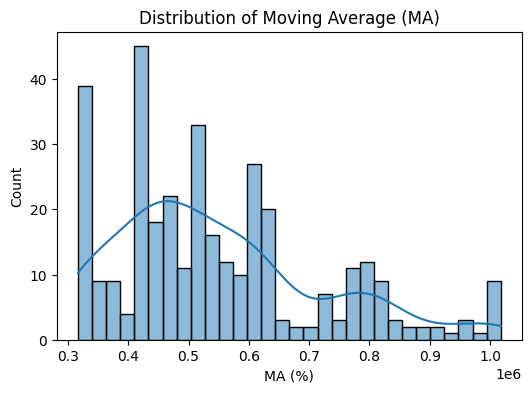

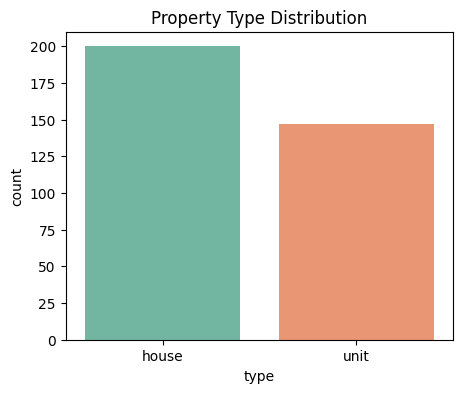

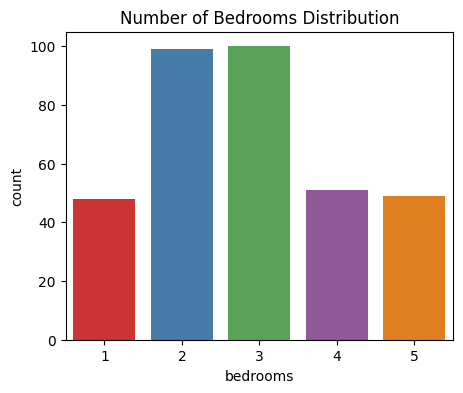

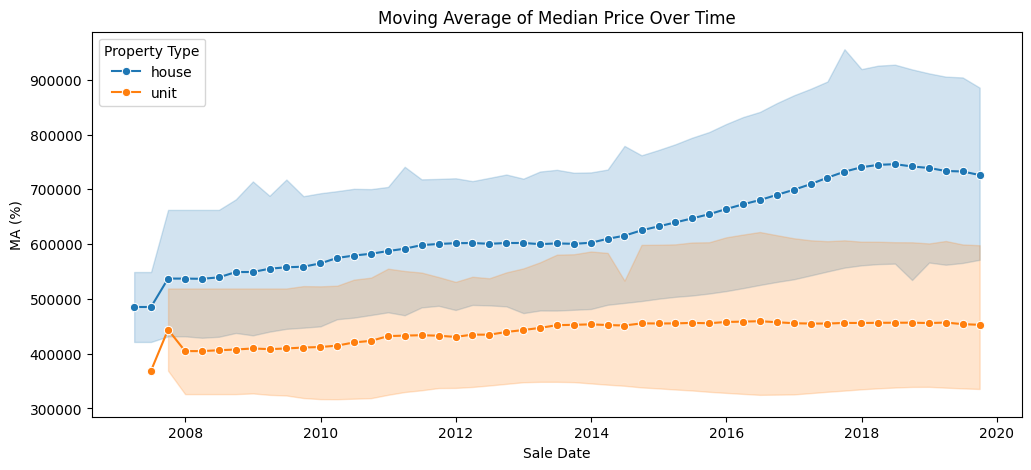


Average MA per property type:
 type
house    627797.805000
unit     439743.102041
Name: MA, dtype: float64

Average MA per bedroom:
 bedrooms
1    332724.416667
2    443113.232323
3    543407.440000
4    669803.803922
5    854328.102041
Name: MA, dtype: float64


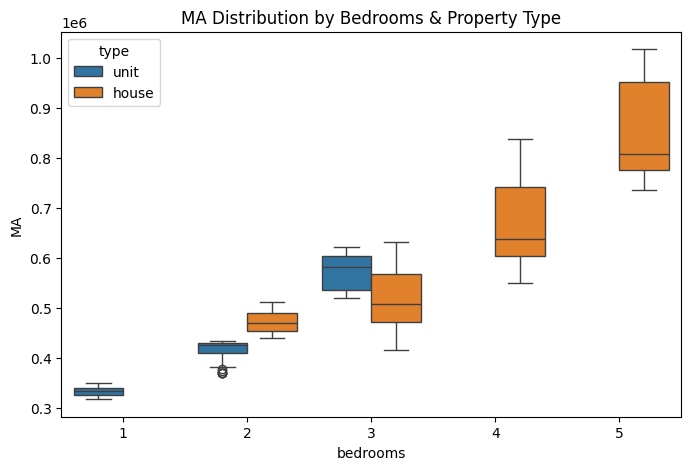

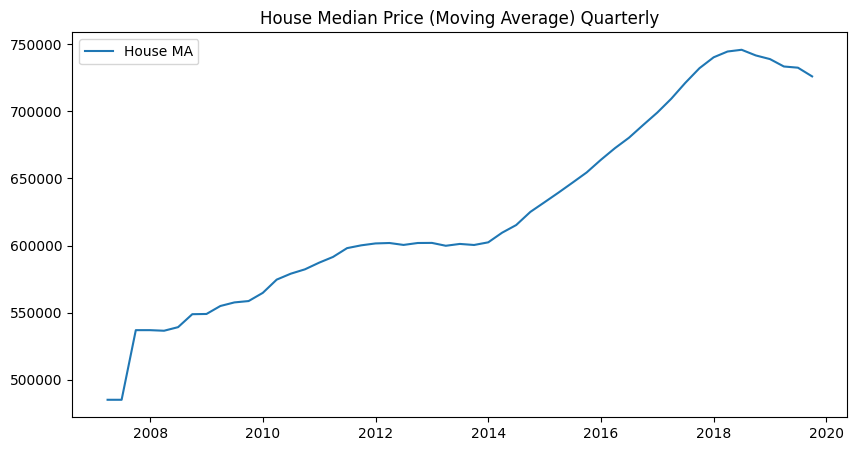

                               SARIMAX Results                                
Dep. Variable:                     MA   No. Observations:                   51
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -528.575
Date:                Wed, 03 Sep 2025   AIC                           1063.150
Time:                        17:39:30   BIC                           1068.886
Sample:                    03-31-2007   HQIC                          1065.335
                         - 09-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000      0.363     -2.755      0.006      -1.711      -0.289
ma.L1          1.0000      0.465      2.153      0.031       0.090       1.910
sigma2      8.748e+07   3.97e-08    2.2e+15      0.0

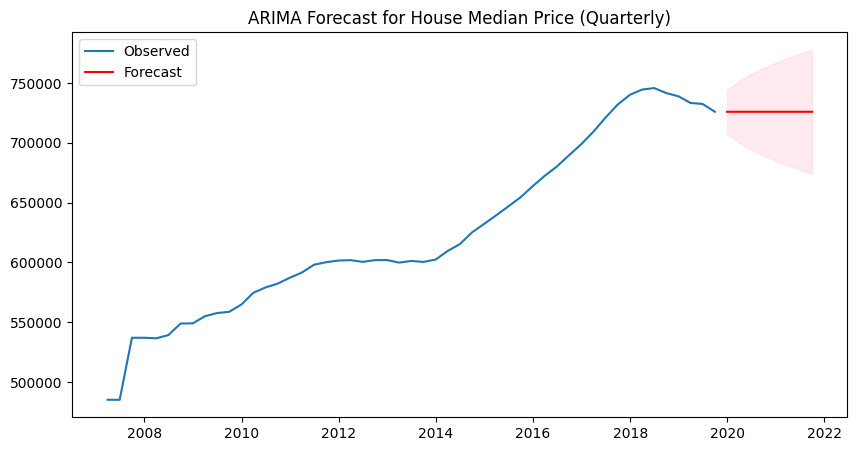

Quarterly points available: 51
Training samples: 44, Vector dim (D): 8
Epoch 01 | Avg log p(x): -5.5282 | NLL: 5.5282
Epoch 02 | Avg log p(x): -5.4832 | NLL: 5.4832
Epoch 03 | Avg log p(x): -5.4389 | NLL: 5.4389
Epoch 04 | Avg log p(x): -5.3952 | NLL: 5.3952
Epoch 05 | Avg log p(x): -5.3522 | NLL: 5.3522
Epoch 06 | Avg log p(x): -5.3098 | NLL: 5.3098
Epoch 07 | Avg log p(x): -5.2680 | NLL: 5.2680
Epoch 08 | Avg log p(x): -5.2267 | NLL: 5.2267
Epoch 09 | Avg log p(x): -5.1859 | NLL: 5.1859
Epoch 10 | Avg log p(x): -5.1457 | NLL: 5.1457
Epoch 11 | Avg log p(x): -5.1059 | NLL: 5.1059
Epoch 12 | Avg log p(x): -5.0666 | NLL: 5.0666
Epoch 13 | Avg log p(x): -5.0278 | NLL: 5.0278
Epoch 14 | Avg log p(x): -4.9894 | NLL: 4.9894
Epoch 15 | Avg log p(x): -4.9513 | NLL: 4.9513
Epoch 16 | Avg log p(x): -4.9136 | NLL: 4.9136
Epoch 17 | Avg log p(x): -4.8762 | NLL: 4.8762
Epoch 18 | Avg log p(x): -4.8392 | NLL: 4.8392
Epoch 19 | Avg log p(x): -4.8024 | NLL: 4.8024
Epoch 20 | Avg log p(x): -4.7660 | N

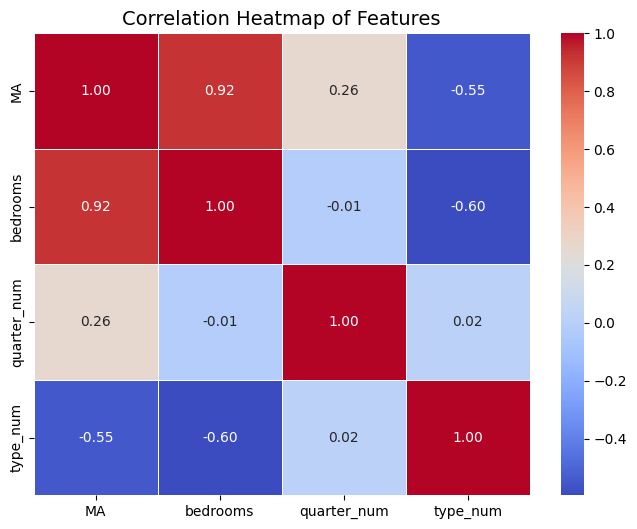

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings("ignore")
torch.manual_seed(42)
np.random.seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

df = pd.read_csv("1.csv")
print("Shape of dataset:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce', dayfirst=True)
df['MA'] = df['MA'].astype(str).str.replace('%','').astype(float)

print("\nSummary Stats (Numeric):\n", df.describe())
print("\nUnique values in categorical columns:\n")
print("type:", df['type'].unique())
print("bedrooms:", df['bedrooms'].unique())

plt.figure(figsize=(6,4))
sns.histplot(df['MA'], bins=30, kde=True)
plt.title("Distribution of Moving Average (MA)")
plt.xlabel("MA (%)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(5,4))
sns.countplot(x='type', data=df, palette='Set2')
plt.title("Property Type Distribution")
plt.show()

plt.figure(figsize=(5,4))
sns.countplot(x='bedrooms', data=df, palette='Set1')
plt.title("Number of Bedrooms Distribution")
plt.show()

plt.figure(figsize=(12,5))
sns.lineplot(x='saledate', y='MA', hue='type', data=df, marker='o')
plt.title("Moving Average of Median Price Over Time")
plt.xlabel("Sale Date")
plt.ylabel("MA (%)")
plt.legend(title="Property Type")
plt.show()

print("\nAverage MA per property type:\n", df.groupby('type')['MA'].mean())
print("\nAverage MA per bedroom:\n", df.groupby('bedrooms')['MA'].mean())

plt.figure(figsize=(8,5))
sns.boxplot(x='bedrooms', y='MA', hue='type', data=df)
plt.title("MA Distribution by Bedrooms & Property Type")
plt.show()

df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce', dayfirst=True)
df['MA'] = df['MA'].astype(str).str.replace('%','').astype(float)
df['MA'] = df['MA'].ffill()
df_house = df[df['type']=='house']
df_house = df_house.groupby('saledate')['MA'].mean().reset_index()
df_house = df_house.set_index('saledate').resample('QE').mean()

plt.figure(figsize=(10,5))
plt.plot(df_house['MA'], label='House MA')
plt.title("House Median Price (Moving Average) Quarterly")
plt.legend()
plt.show()

model = sm.tsa.ARIMA(df_house['MA'], order=(1,1,1))
results = model.fit()
print(results.summary())

forecast = results.get_forecast(steps=8)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(10,5))
plt.plot(df_house['MA'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color='pink', alpha=0.3)
plt.title("ARIMA Forecast for House Median Price (Quarterly)")
plt.legend()
plt.show()

df = pd.read_csv("1.csv")
df.columns = df.columns.str.strip()
df["saledate"] = pd.to_datetime(df["saledate"], errors="coerce", dayfirst=True)
df["MA"] = df["MA"].astype(str).str.replace("%", "", regex=False).str.replace(",", "", regex=False).astype(float)
df = df.dropna(subset=["saledate", "MA"]).copy()
df = df.sort_values("saledate")
df["type"] = df["type"].astype(str).str.lower().str.strip()
df["bedrooms"] = pd.to_numeric(df["bedrooms"], errors="coerce")

ts = df[["saledate", "MA"]].set_index("saledate").resample("QE").mean().ffill()
print(f"Quarterly points available: {len(ts)}")

WINDOW = 8
series = ts["MA"].values.astype(np.float32)
s_min, s_max = series.min(), series.max()
norm = (series - s_min) / (s_max - s_min) if s_max != s_min else np.zeros_like(series)
threshold = np.nanmedian(norm)
binary = (norm >= threshold).astype(np.float32)

X = []
for i in range(len(binary) - WINDOW + 1):
    X.append(binary[i:i+WINDOW])
X = np.stack(X, axis=0) if len(binary) >= WINDOW else np.empty((0, WINDOW), dtype=np.float32)
if X.shape[0] == 0:
    raise ValueError("Not enough quarterly points to create windows.")
X_t = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X_t)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=False)
print(f"Training samples: {len(dataset)}, Vector dim (D): {WINDOW}")

class FVSBN(nn.Module):
    def __init__(self, dim, hidden_size=128):
        super().__init__()
        self.dim = dim
        self.hidden = nn.Linear(dim, hidden_size)
        self.act = nn.ReLU()
        self.out = nn.Linear(hidden_size, dim)
        nn.init.zeros_(self.out.bias)
    def forward(self, x, forward_mask=None):
        x_masked = x * forward_mask if forward_mask is not None else x
        h = self.act(self.hidden(x_masked))
        return self.out(h)
    def log_prob(self, x):
        B, D = x.shape
        total_lp = x.new_zeros(B)
        for i in range(D):
            mask = torch.zeros_like(x)
            if i > 0:
                mask[:, :i] = 1.0
            logits = self.forward(x, forward_mask=mask)
            logp_i = -nn.functional.binary_cross_entropy_with_logits(logits[:, i], x[:, i], reduction="none")
            total_lp += logp_i
        return total_lp
    @torch.no_grad()
    def sample(self, n_samples=1):
        samples = torch.zeros((n_samples, self.dim), device=next(self.parameters()).device)
        for i in range(self.dim):
            mask = torch.zeros_like(samples)
            if i > 0:
                mask[:, :i] = 1.0
            logits = self.forward(samples, forward_mask=mask)
            probs = torch.sigmoid(logits[:, i])
            u = torch.rand_like(probs)
            samples[:, i] = (u < probs).float()
        return samples.cpu().numpy()

D = WINDOW
model = FVSBN(dim=D, hidden_size=128).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 25
for epoch in range(1, EPOCHS + 1):
    model.train()
    total_ll, n_seen = 0.0, 0
    for (xb,) in dataloader:
        xb = xb.to(device)
        opt.zero_grad()
        logp = model.log_prob(xb)
        loss = -logp.mean()
        loss.backward()
        opt.step()
        total_ll += logp.sum().item()
        n_seen += xb.size(0)
    avg_ll = total_ll / n_seen
    print(f"Epoch {epoch:02d} | Avg log p(x): {avg_ll:.4f} | NLL: {-avg_ll:.4f}")

with torch.no_grad():
    gen_bin = model.sample(n_samples=5)
low_val, high_val = 0.25, 0.75
gen_norm = np.where(gen_bin < 0.5, low_val, high_val)
gen_MA = gen_norm * (s_max - s_min) + s_min
print("\nGenerated binary windows (0/1):")
print(gen_bin)
print("\nGenerated MA (%) windows (approximate, using 25/75% mapping):")
print(np.round(gen_MA, 2))

df['saledate'] = pd.to_datetime(df['saledate'], dayfirst=True, errors='coerce')
df['quarter'] = df['saledate'].dt.to_period('Q').astype(str)
df['quarter_num'] = pd.factorize(df['quarter'])[0] + 1
df['type_num'] = df['type'].map({'house':0, 'unit':1})
numeric_df = df[['MA', 'bedrooms', 'quarter_num', 'type_num']]
corr = numeric_df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Features", fontsize=14)
plt.show()


# EXP5 - Implement NADE and train it on a dataset like CIFAR-10 for image generation.



- Dataset & Preprocessing – Loads the CIFAR-10 dataset, flattens each image (32×32×3 = 3072 pixels) for autoregressive modeling.

- Masked Linear Layers – Uses custom MaskedLinear to enforce autoregressive constraints so that each pixel depends only on previous pixels.

- FastNADE Model – Implements NADE with one hidden layer, applying masks to both input → hidden and hidden → output connections.

- Training – Trains the model with binary cross-entropy loss to reconstruct images, optimizing with Adam.

- Image Generation – Sequentially samples pixels one by one from the trained model to generate new synthetic CIFAR-10-like images.

100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


Epoch [1/10], Loss: 0.6538
Epoch [2/10], Loss: 0.6393
Epoch [3/10], Loss: 0.6351
Epoch [4/10], Loss: 0.6328
Epoch [5/10], Loss: 0.6314
Epoch [6/10], Loss: 0.6302
Epoch [7/10], Loss: 0.6293
Epoch [8/10], Loss: 0.6286
Epoch [9/10], Loss: 0.6279
Epoch [10/10], Loss: 0.6275


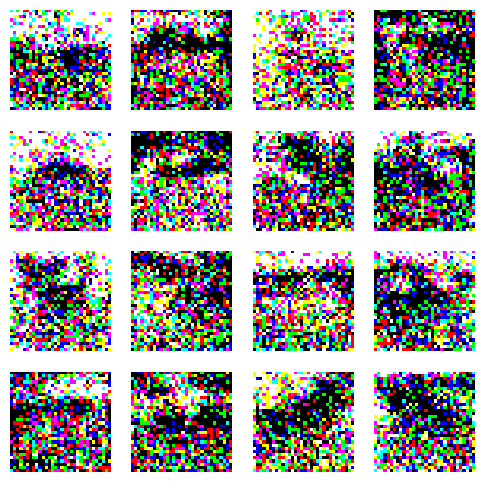

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, mask):
        super().__init__(in_features, out_features)
        self.register_buffer('mask', mask)
    def forward(self, x):
        return nn.functional.linear(x, self.weight * self.mask, self.bias)

class FastNADE(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        mask_in = torch.tril(torch.ones(hidden_dim, input_dim))
        self.fc1 = MaskedLinear(input_dim, hidden_dim, mask_in)
        mask_out = torch.tril(torch.ones(input_dim, hidden_dim), diagonal=-1)
        self.fc2 = MaskedLinear(hidden_dim, input_dim, mask_out)
    def forward(self, x):
        h = torch.sigmoid(self.fc1(x))
        out = torch.sigmoid(self.fc2(h))
        return out

input_dim = 32*32*3
hidden_dim = 500
model = FastNADE(input_dim, hidden_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, _ in train_loader:
        images = images.view(images.size(0), -1).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

model.eval()
n_samples = 16
samples = torch.zeros(n_samples, input_dim, device=device)
with torch.no_grad():
    for i in range(input_dim):
        out = model(samples)
        samples[:, i] = (torch.rand(n_samples, device=device) < out[:, i]).float()
samples = samples.view(n_samples, 3, 32, 32).cpu()

fig, axes = plt.subplots(4, 4, figsize=(6,6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].permute(1,2,0))
    ax.axis('off')
plt.show()
